#**🧾 1. Introduction**

This notebook analyses the Diabetes 130-US Hospitals dataset from the UCI Machine Learning Repository. The primary goal is to analyze patient readmission patterns and identify key predictors using Logistic Regression.

Dataset Source: UCI ML Repository (ID: 296)

Domain: Healthcare

Focus: 30-day hospital readmission for diabetic


# **🧭 Environment Setup & Reproducibility**

Initialize the environment for consistency. Sets random seed for reproducibility, configures pandas display options, and loads essential packages (numpy, pandas).

In [1]:
# ============================================
# 0) Environment Setup & Reproducibility
# ============================================

import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 120)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("✅ Environment ready. Random state set to", RANDOM_STATE)

✅ Environment ready. Random state set to 42


# **📂 Load Dataset**

Import the dataset (df_filtered_first_encounter_mapped.csv) and inspect its structure — shape, columns, and a sample preview — to ensure it loads correctly before modeling.

In [2]:
# ============================================
# 1) Load Dataset
# ============================================

df = pd.read_csv("df_filtered_first_encounter_mapped_eng_feature.csv")
print("✅ Dataset loaded")
print("Shape:", df.shape)
print("First 10 columns:", df.columns[:10].tolist())
display(df.head())

✅ Dataset loaded
Shape: (59094, 122)
First 10 columns: ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum']


,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,comorbidity_score,filtered_meds_count,service_utilization,readmitted_flag,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,change_No,diabetesMed_Yes,discharge_disposition_name_Discharged to home,discharge_disposition_name_Discharged/transferred to ICF,discharge_disposition_name_Discharged/transferred to SNF,discharge_disposition_name_Discharged/transferred to a federal health care facility.,discharge_disposition_name_Discharged/transferred to a long term care hospital.,discharge_disposition_name_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,discharge_disposition_name_Discharged/transferred to another rehab fac including rehab units of a hospital .,discharge_disposition_name_Discharged/transferred to another short term hospital,discharge_disposition_name_Discharged/transferred to another type of inpatient care institution,discharge_disposition_name_Discharged/transferred to home under care of Home IV provider,discharge_disposition_name_Discharged/transferred to home with home health service,discharge_disposition_name_Discharged/transferred within this institution to Medicare approved swing bed,discharge_disposition_name_Discharged/transferred/referred another institution for outpatient services,discharge_disposition_name_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,discharge_disposition_name_Discharged/transferred/referred to this institution for outpatient services,discharge_disposition_name_Expired,"discharge_disposition_name_Expired at home. Medicaid only, hospice.","discharge_disposition_name_Expired in a medical facility. Medicaid only, hospice.",discharge_disposition_name_Hospice / home,discharge_disposition_name_Hospice / medical facility,discharge_disposition_name_Left AMA,discharge_disposition_name_Neonate discharged to another hospital for neonatal aftercare,discharge_disposition_name_Not Mapped,discharge_disposition_name_Still patient or expected to return for outpatient services,admission_type_name_Emergency,admission_type_name_Not Available,admission_type_name_Not Mapped,admission_type_name_Others (Low Incidence),admission_type_name_Urgent,admission_source_name_ Not Available,...,admission_source_name_ Transfer from a Skilled Nursing Facility (SNF),admission_source_name_ Transfer from another health care facility,admission_source_name_Clinic Referral,admission_source_name_HMO Referral,admission_source_name_Others (Low Incidence),admission_source_name_Transfer from a hospital,diag_1_category_Circulatory System,diag_1_category_Congenital Anomalies,diag_1_category_Digestive System,"diag_1_category_Endocrine, Nutritional, Metabolic",diag_1_category_External Causes (E codes),diag_1_category_Genitourinary System,diag_1_category_Infectious and Parasitic Diseases,diag_1_category_Injury and Poisoning,diag_1_category_Mental Disorders,diag_1_category_Musculoskeletal System,diag_1_category_Neoplasms,diag_1_category_Nervous System and Sense Organs,diag_1_category_Pregnancy and Childbirth,diag_1_category_Respiratory System,diag_1_category_Skin and Subcutaneous Tissue,diag_1_category_Supplementary Factors (V codes),diag_1_category_Symptoms and Ill-Defined Conditions,diag_1_category_Unknown,diag_2_category_Circulatory System,diag_2_category_Congenital Anomalies,diag_2_category_Digestive System,"diag_2_category_Endocrine, Nutritional, Metabolic",diag_2_category_External Causes (E codes),diag_2_category_Genitourinary System,diag_2_category_Infectious and Parasitic Diseases,diag_2_category_Injury and Poisoning,diag_2_category_Mental Disorders,diag_2_category_Musculoskeletal System,diag_2_category_Neoplasms,diag_2_category_Nervous System and Sense Organs,

# **⚙️ Train/Test Split + Scaling**

Split data into training and testing sets (80/20) using train_test_split with stratification for class balance. Standardize features with StandardScaler to ensure all variables have comparable scale for logistic regression.

In [3]:
# ============================================
# 2) Train/Test Split + Scaling
# ============================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = "readmitted_flag"         # <-- change if your target col is different
drop_cols = [c for c in ["Unnamed: 0"] if c in df.columns]

X = df.drop(columns=[target] + drop_cols)
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print("✅ Split complete")
print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"y_train: {y_train.shape} | y_test: {y_test.shape}")
print(f"Positive rate (train): {y_train.mean():.3f}")

scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns,  index=X_test.index)
print("✅ Features standardized (z-scores)")

✅ Split complete
X_train: (47275, 121) | X_test: (11819, 121)
y_train: (47275,) | y_test: (11819,)
Positive rate (train): 0.146
✅ Features standardized (z-scores)


# **🧠 Helper: Train L1 Logistic Regression + CV AUC**

Define a helper function to train L1 (LASSO) Logistic Regression using cross-validation (CV).
The function returns both the model and average CV AUC, helping assess generalization before final fitting.

In [4]:
# ============================================
# 3) Helper: Train L1 Logistic Regression + CV AUC
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def train_l1_logreg(Xtr, ytr, C=0.1, class_weight="balanced", cv=5, scoring = "roc_auc", seed=RANDOM_STATE):
    model = LogisticRegression(
        penalty="l1", solver="liblinear", C=C,
        class_weight=class_weight, max_iter=1000, random_state=seed
    )
    cv_metric = cross_val_score(model, Xtr, ytr, cv=cv, scoring=scoring).mean()
    model.fit(Xtr, ytr)
    return model, cv_metric


# **🔍 Optimize Regularization (C) + Class Balancing via CV AUC**

Perform grid search across different regularization strengths (C) and class weighting schemes.
The best model is selected based on the highest cross-validated AUC, balancing recall vs precision under class imbalance.

In [23]:
  # ============================================
# 4) Optimize Regularization (C) + Class Balancing via CV AUC
# ============================================

grid_C = [0.01, 0.02, 0.05, 0.1, 0.2]
grid_classw = [
    "balanced",
    {0:1.0, 1:1.5},
    {0:1.0, 1:2.0},
    {0:1.0, 1:5.0},
    {0:1.0, 1:6.0},
    {0:1.5, 1:1.0},  # penalize FP more
    {0:2.0, 1:1.0},  # penalize FP even more
]

results = []
best = {"auc": -1, "C": None, "class_weight": None, "model": None}
for C in grid_C:
    for cw in grid_classw:
        m, auc_cv = train_l1_logreg(X_train_s, y_train, C=C, class_weight=cw, cv=5)
        results.append({"C": C, "class_weight": cw, "cv_auc": auc_cv})
        if auc_cv > best["auc"]:
            best.update({"auc": auc_cv, "C": C, "class_weight": cw, "model": m})

cv_table = pd.DataFrame(results).sort_values("cv_auc", ascending=False)
print("📊 CV AUC grid (top 10):")
display(cv_table.head(10))
print(f"⭐ Best params: C={best['C']} | class_weight={best['class_weight']} | CV AUC={best['auc']:.3f}")

model_L1 = best["model"]

📊 CV AUC grid (top 10):


,C,class_weight,cv_auc
3,0.01,"{0: 1.0, 1: 5.0}",0.701042
0,0.01,balanced,0.701040
4,0.01,"{0: 1.0, 1: 6.0}",0.701039
7,0.02,balanced,0.701010
10,0.02,"{0: 1.0, 1: 5.0}",0.700767
11,0.02,"{0: 1.0, 1: 6.0}",0.700736
9,0.02,"{0: 1.0, 1: 2.0}",0.700717
8,0.02,"{0: 1.0, 1: 1.5}",0.700578
2,0.01,"{0: 1.0, 1: 2.0}",0.700564
14,0.05,balanced,0.700563


⭐ Best params: C=0.01 | class_weight={0: 1.0, 1: 5.0} | CV AUC=0.701


# **🎯 Fine-tune Threshold (pick by F1 or Target Precision)**

Sweep through thresholds from 0.3 to 0.8 and compute Precision, Recall, and F1 at each level.

Choose either:
*   The threshold that maximizes F1, or
*   The smallest threshold achieving a target precision (if specified).

This step aligns the model’s decision cutoff to business priorities.

In [24]:
# ============================================
# 5) Fine-tune Threshold (pick by F1 or Target Precision)
# ============================================

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

TARGET_PRECISION = None     # e.g., 0.35 to enforce minimum precision; or None to maximize F1
SCAN = np.arange(0.30, 0.81, 0.01)

y_prob = model_L1.predict_proba(X_test_s)[:, 1]
y_train_prob = model_L1.predict_proba(X_train_s)[:, 1]
thr_rows = []
for t in SCAN:
    y_pred = (y_prob >= t).astype(int)
    y_train_pred = (y_train_prob >= t).astype(int)
    thr_rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall":    recall_score(y_test, y_pred, zero_division=0),
        "f1":        f1_score(y_test, y_pred, zero_division=0),
        "precision_tr": precision_score(y_train, y_train_pred, zero_division=0),
        "recall_tr":    recall_score(y_train, y_train_pred, zero_division=0),
        "f1_tr":        f1_score(y_train, y_train_pred, zero_division=0)
    })
thr_df = pd.DataFrame(thr_rows)

if TARGET_PRECISION is not None:
    candidates = thr_df[thr_df["precision"] >= TARGET_PRECISION]
    best_thr = candidates.iloc[0]["threshold"] if len(candidates) else thr_df.loc[thr_df["precision"].idxmax(),"threshold"]
else:
    best_thr = thr_df.loc[thr_df["f1"].idxmax(),"threshold"]

t = float(best_thr)
print("🔧 Chosen threshold:", round(t, 2))
display(thr_df.sort_values(["f1","precision"], ascending=False).head(10))

# Evaluate at chosen threshold
y_pred = (y_prob >= t).astype(int)
y_train_pred = (y_train_prob >= t).astype(int)
print(f"🔎 Evaluation @ threshold = {t:.2f}")
print(f"AUC (probabilities): {roc_auc_score(y_test, y_prob):.3f}")
print(f"AUC (probabilities): {roc_auc_score(y_train, y_train_prob):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
cm_tr = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:\n", cm)
print("Confusion Matrix (Train):\n", cm_tr)
print(f"TN={cm[0,0]}  FP={cm[0,1]}  FN={cm[1,0]}  TP={cm[1,1]}")
print(f"TN={cm_tr[0,0]}  FP={cm_tr[0,1]}  FN={cm_tr[1,0]}  TP={cm_tr[1,1]}")

🔧 Chosen threshold: 0.52


,threshold,precision,recall,f1,precision_tr,recall_tr,f1_tr
22,0.52,0.291786,0.473623,0.361105,0.286242,0.460301,0.352980
24,0.54,0.305310,0.440000,0.360484,0.296677,0.417850,0.346989
23,0.53,0.296869,0.456232,0.359689,0.290366,0.436685,0.348802
25,0.55,0.312663,0.417971,0.357728,0.302770,0.399015,0.344293
21,0.51,0.280333,0.487536,0.355979,0.280569,0.483048,0.354964
19,0.49,0.266744,0.533333,0.355624,0.270567,0.532744,0.358872
20,0.50,0.272079,0.508986,0.354604,0.275263,0.507534,0.356939
26,0.56,0.318140,0.396522,0.353032,0.309803,0.382788,0.342450
27,0.57,0.328500,0.380870,0.352752,0.314915,0.362504,0.337038
18,0.48,0.259007,0.550145,0.352199,0.263556,0.555636,0.357526


🔎 Evaluation @ threshold = 0.52
AUC (probabilities): 0.708
AUC (probabilities): 0.708

Classification Report:
              precision    recall  f1-score   support

           0      0.899     0.804     0.849     10094
           1      0.292     0.474     0.361      1725

    accuracy                          0.755     11819
   macro avg      0.596     0.639     0.605     11819
weighted avg      0.811     0.755     0.778     11819


Classification Report (Train):
              precision    recall  f1-score   support

           0      0.897     0.804     0.848     40373
           1      0.286     0.460     0.353      6902

    accuracy                          0.754     47275
   macro avg      0.592     0.632     0.600     47275
weighted avg      0.808     0.754     0.776     47275

Confusion Matrix:
 [[8111 1983]
 [ 908  817]]
Confusion Matrix (Train):
 [[32451  7922]
 [ 3725  3177]]
TN=8111  FP=1983  FN=908  TP=817
TN=32451  FP=7922  FN=3725  TP=3177


# **📊 Quick Plots (Pre-Refinement)**

Generate visual diagnostics to understand baseline model behavior:

*   Confusion Matrix (prediction errors)
*   ROC Curve (AUC performance)
*   Precision–Recall Curve (useful for imbalanced data)

These charts help visualize trade-offs between false positives and recall before refinement.

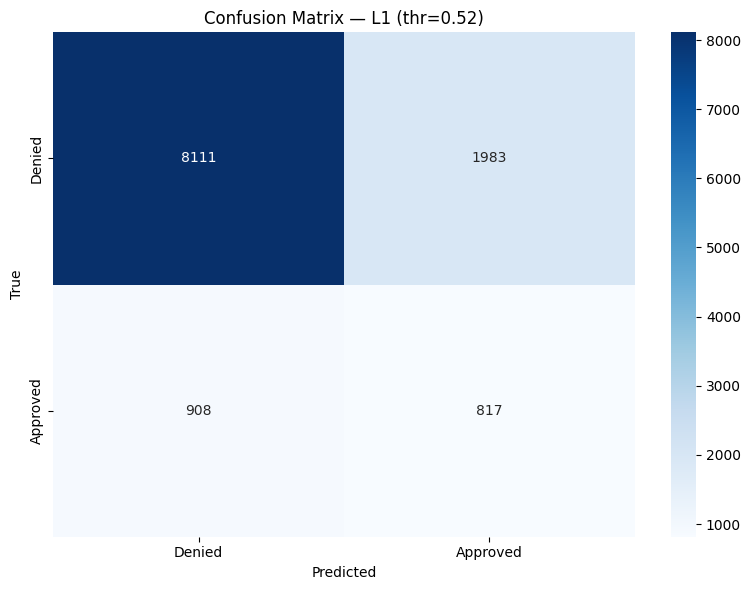

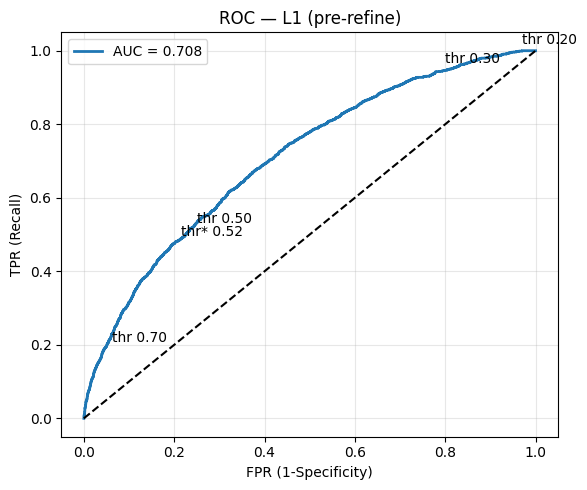

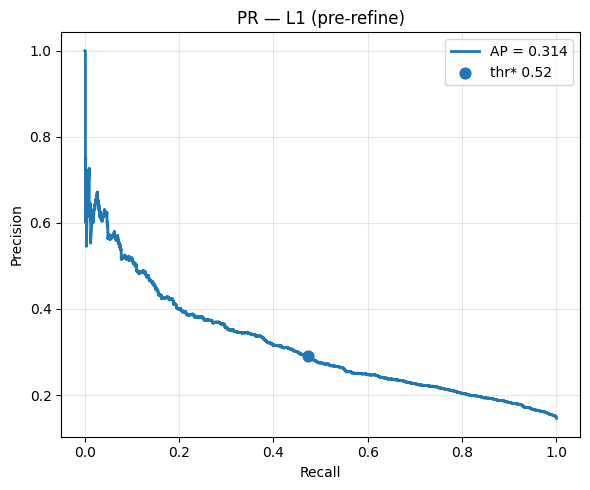

In [25]:
# ============================================
# 6) Quick plots before refinement
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Denied','Approved'], yticklabels=['Denied','Approved'])
plt.title(f'Confusion Matrix — L1 (thr={t:.2f})'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

fpr, tpr, thr = roc_curve(y_test, y_prob); roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0,1],[0,1],'k--');
for thv in [0.2,0.3,0.5,0.7,t]:
    idx = np.argmin(np.abs(thr - thv)); lbl = f"thr {thv:.2f}" if thv!=t else f"thr* {thv:.2f}"
    plt.annotate(lbl, (fpr[idx], tpr[idx]), xytext=(6,6), textcoords="offset points")
plt.xlabel("FPR (1-Specificity)"); plt.ylabel("TPR (Recall)")
plt.title("ROC — L1 (pre-refine)"); plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout(); plt.show()

prec, rec, pr_thr = precision_recall_curve(y_test, y_prob); ap = average_precision_score(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {ap:.3f}", linewidth=2)
idxs = np.argmin(np.abs(pr_thr - t))
plt.scatter(rec[idxs], prec[idxs], s=60, label=f"thr* {t:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — L1 (pre-refine)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# **✂️ Drop Weakest Features (|coef| < 0.02) & Refit Model**

Identify and remove low-impact predictors (those with small absolute L1 coefficients).

This improves model interpretability and generalization by reducing noise.

The reduced model is retrained using the previously optimized hyperparameters (best C and class_weight).

In [26]:
# ============================================
# 7) Drop the 10 Weakest Features (smallest |coef|), then Refit
# ============================================

NUM_TO_DROP = 87

coefs = pd.Series(model_L1.coef_[0], index=X_train_s.columns).to_frame("Coefficient")
coefs["Abs"] = coefs["Coefficient"].abs()
coefs_sorted = coefs.sort_values("Abs", ascending=True)  # weakest first

print(f"🔎 Weakest {NUM_TO_DROP} features (to drop):")
display(coefs_sorted.head(NUM_TO_DROP))

to_drop = coefs_sorted.head(NUM_TO_DROP).index.tolist()
X_train_s2 = X_train_s.drop(columns=to_drop)
X_test_s2  = X_test_s.drop(columns=to_drop)
print(f"✂️ Dropped {len(to_drop)} features. New shapes: {X_train_s2.shape} / {X_test_s2.shape}")

# Refit with BEST params from CV
model_L1_reduced, cv_auc_reduced = train_l1_logreg(
    X_train_s2, y_train, C=best["C"], class_weight=best["class_weight"], cv=5
)
print(f"📊 CV AUC after drop: {cv_auc_reduced:.3f} (was {best['auc']:.3f})")

🔎 Weakest 87 features (to drop):


,Coefficient,Abs
number_outpatient,0.000000,0.000000
discharge_disposition_name_Discharged/transferred to ICF,0.000000,0.000000
change_No,0.000000,0.000000
rosiglitazone,0.000000,0.000000
discharge_disposition_name_Left AMA,0.000000,0.000000
admission_type_name_Emergency,0.000000,0.000000
discharge_disposition_name_Discharged/transferred to home under care of Home IV provider,0.000000,0.000000
diag_2_category_Mental Disorders,0.000000,0.000000
diag_1_category_Skin and Subcutaneous Tissue,0.000000,0.000000
diag_2_category_Congenital Anomalies,0.000000,0.000000


✂️ Dropped 87 features. New shapes: (47275, 34) / (11819, 34)
📊 CV AUC after drop: 0.701 (was 0.701)


# **🔧 Re-Optimize Threshold on Reduced Feature Set**

Re-run the threshold optimization process on the refined model to recalibrate its decision boundary.

This ensures the new, simpler model still achieves a balanced trade-off between sensitivity and specificity.

In [27]:
# ============================================
# 8) Threshold selection AGAIN on reduced feature set
# ============================================

y_prob2 = model_L1_reduced.predict_proba(X_test_s2)[:, 1]
y_train_prob2 = model_L1_reduced.predict_proba(X_train_s2)[:, 1]
thr_rows2 = []
for tt in SCAN:
    yp = (y_prob2 >= tt).astype(int)
    yp_tr = (y_train_prob2 >= tt).astype(int)
    thr_rows2.append({
        "threshold": tt,
        "precision": precision_score(y_test, yp, zero_division=0),
        "recall":    recall_score(y_test, yp, zero_division=0),
        "f1":        f1_score(y_test, yp, zero_division=0),
        "precision_tr": precision_score(y_train, yp_tr, zero_division=0),
        "recall_tr":    recall_score(y_train, yp_tr, zero_division=0),
        "f1_tr":        f1_score(y_train, yp_tr, zero_division=0)
    })
thr_df2 = pd.DataFrame(thr_rows2)

if TARGET_PRECISION is not None:
    cand2 = thr_df2[thr_df2["precision"] >= TARGET_PRECISION]
    best_thr2 = cand2.iloc[0]["threshold"] if len(cand2) else thr_df2.loc[thr_df2["precision"].idxmax(),"threshold"]
else:
    best_thr2 = thr_df2.loc[thr_df2["f1"].idxmax(),"threshold"]

t2 = float(best_thr2)
print("🔧 New chosen threshold (reduced):", round(t2, 2))
display(thr_df2.sort_values(["f1","precision"], ascending=False).head(10))

# Final eval on reduced model
y_pred2 = (y_prob2 >= t2).astype(int)
y_train_pred2 = (y_train_prob2 >= t2).astype(int)
print(f"\n🔎 Final Evaluation @ threshold = {t2:.2f}")
print(f"AUC (probabilities): {roc_auc_score(y_test, y_prob2):.3f}")
print(f"AUC (probabilities) Train: {roc_auc_score(y_train, y_train_prob2):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred2, digits=3))
print("\nClassification Report: Train")
print(classification_report(y_train, y_train_pred2, digits=3))
cm2 = confusion_matrix(y_test, y_pred2)
cm2_tr = confusion_matrix(y_train, y_train_pred2)
print("Confusion Matrix:\n", cm2)

print(f"TN={cm2[0,0]}  FP={cm2[0,1]}  FN={cm2[1,0]}  TP={cm2[1,1]}")
print("Confusion Matrix Train:\n", cm2_tr)
print(f"TN={cm2_tr[0,0]}  FP={cm2_tr[0,1]}  FN={cm2_tr[1,0]}  TP={cm2_tr[1,1]}")

🔧 New chosen threshold (reduced): 0.51


,threshold,precision,recall,f1,precision_tr,recall_tr,f1_tr
21,0.51,0.284859,0.496232,0.361945,0.278276,0.476239,0.351288
23,0.53,0.299694,0.454493,0.361207,0.292353,0.434802,0.349624
22,0.52,0.291058,0.473623,0.360547,0.285636,0.455230,0.351022
20,0.50,0.275679,0.511884,0.358360,0.271164,0.495653,0.350548
24,0.54,0.306206,0.431884,0.358345,0.297634,0.411910,0.345569
25,0.55,0.313518,0.412754,0.356356,0.303912,0.395103,0.343559
19,0.49,0.266143,0.530435,0.354445,0.265557,0.519994,0.351570
18,0.48,0.258170,0.549565,0.351306,0.260079,0.544915,0.352104
17,0.47,0.252815,0.572754,0.350790,0.254513,0.569980,0.351894
26,0.56,0.317558,0.388986,0.349661,0.309595,0.375398,0.339336



🔎 Final Evaluation @ threshold = 0.51
AUC (probabilities): 0.708
AUC (probabilities) Train: 0.704

Classification Report:
              precision    recall  f1-score   support

           0      0.901     0.787     0.840     10094
           1      0.285     0.496     0.362      1725

    accuracy                          0.745     11819
   macro avg      0.593     0.642     0.601     11819
weighted avg      0.811     0.745     0.771     11819


Classification Report: Train
              precision    recall  f1-score   support

           0      0.898     0.789     0.840     40373
           1      0.278     0.476     0.351      6902

    accuracy                          0.743     47275
   macro avg      0.588     0.633     0.596     47275
weighted avg      0.808     0.743     0.769     47275

Confusion Matrix:
 [[7945 2149]
 [ 869  856]]
TN=7945  FP=2149  FN=869  TP=856
Confusion Matrix Train:
 [[31848  8525]
 [ 3615  3287]]
TN=31848  FP=8525  FN=3615  TP=3287


# **📈 Post-Refinement Plots & Interpretation**

Comprehensive visual summary of final model performance:

1.   **Confusion Matrix** — Breakdown of predictions
2.   **ROC Curve**— Overall discriminative power (AUC)
3.   **Precision–Recall Curve** — Effectiveness under imbalance
4.   **Threshold Curve** — Precision, Recall, and F1 vs threshold
5.   **Top Coefficients Chart** — Most influential predictors (direction & magnitude)




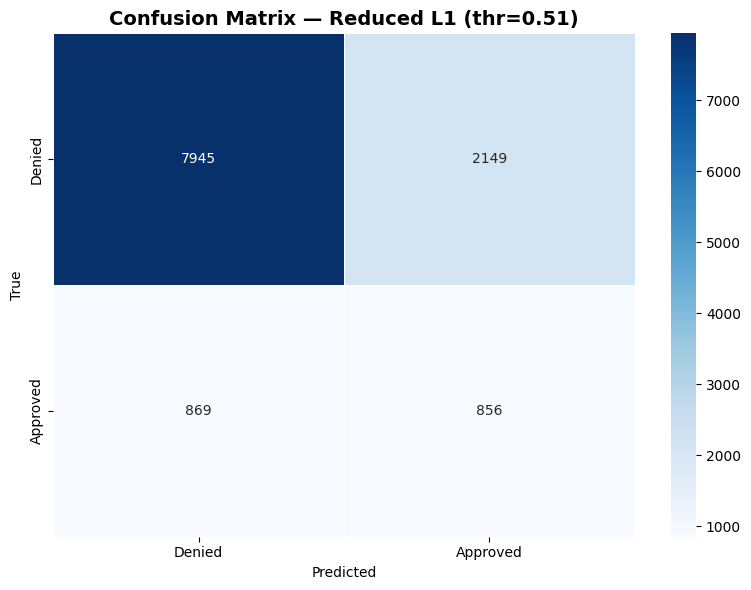

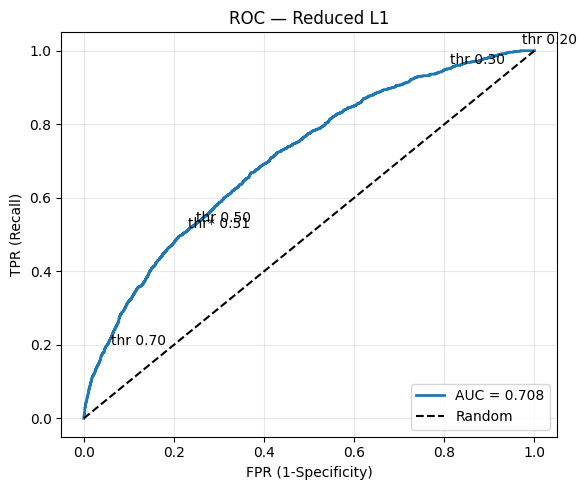

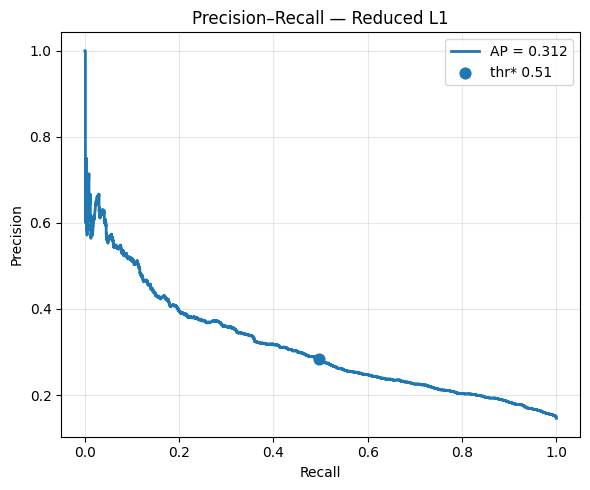

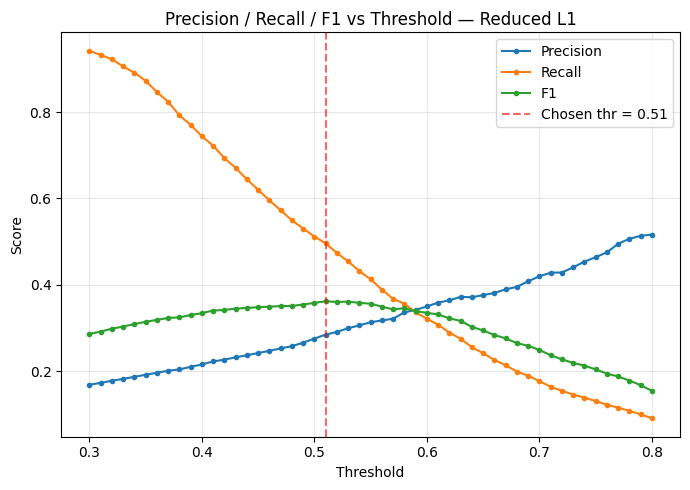

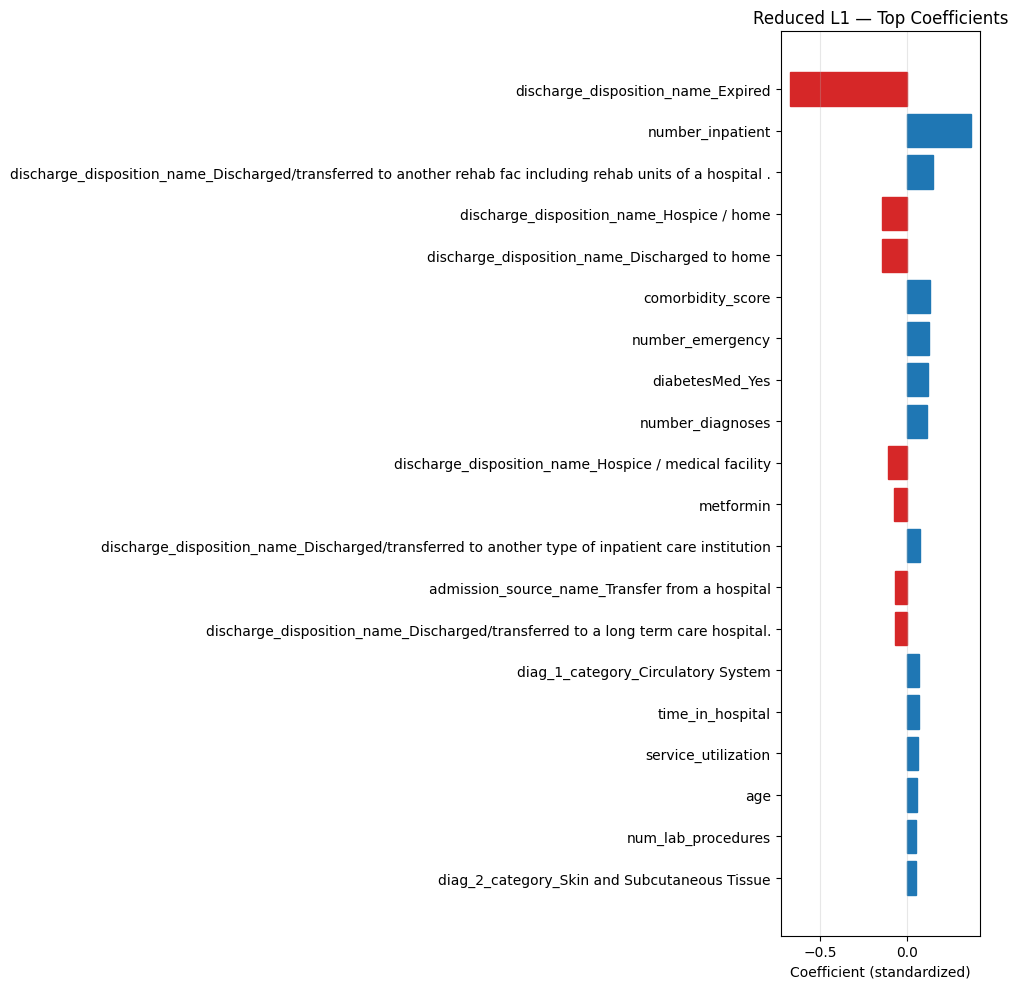

In [28]:
# ============================================
# 9) Post-refinement: All Plots (Confusion, ROC, PR, Threshold Curves, Top Coefs)
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Denied","Approved"], yticklabels=["Denied","Approved"],
            linewidths=0.5, linecolor="white")
plt.title(f"Confusion Matrix — Reduced L1 (thr={t2:.2f})", fontsize=14, fontweight="bold")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ROC (annotated)
fpr2, tpr2, thr2 = roc_curve(y_test, y_prob2); roc_auc2 = auc(fpr2, tpr2)
plt.figure(figsize=(6,5))
plt.plot(fpr2, tpr2, linewidth=2, label=f"AUC = {roc_auc2:.3f}")
plt.plot([0,1],[0,1],"k--", label="Random")
for thv in [0.2,0.3,0.5,0.7,t2]:
    idx = np.argmin(np.abs(thr2 - thv)); lbl = f"thr {thv:.2f}" if thv!=t2 else f"thr* {thv:.2f}"
    plt.annotate(lbl, (fpr2[idx], tpr2[idx]), xytext=(6,6), textcoords="offset points")
plt.xlabel("FPR (1-Specificity)"); plt.ylabel("TPR (Recall)")
plt.title("ROC — Reduced L1"); plt.legend(loc="lower right"); plt.grid(True,alpha=0.3); plt.tight_layout(); plt.show()

# Precision–Recall (annotated)
prec2, rec2, pr_thr2 = precision_recall_curve(y_test, y_prob2); ap2 = average_precision_score(y_test, y_prob2)
plt.figure(figsize=(6,5))
plt.plot(rec2, prec2, linewidth=2, label=f"AP = {ap2:.3f}")
idxs = np.argmin(np.abs(pr_thr2 - t2))
plt.scatter(rec2[idxs], prec2[idxs], s=60, label=f"thr* {t2:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall — Reduced L1")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Threshold curves
plt.figure(figsize=(7,5))
plt.plot(thr_df2["threshold"], thr_df2["precision"], label="Precision", marker="o", ms=3)
plt.plot(thr_df2["threshold"], thr_df2["recall"],    label="Recall",    marker="o", ms=3)
plt.plot(thr_df2["threshold"], thr_df2["f1"],        label="F1",        marker="o", ms=3)
plt.axvline(t2, color="r", linestyle="--", alpha=0.6, label=f"Chosen thr = {t2:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Precision / Recall / F1 vs Threshold — Reduced L1")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Top coefficients (non-zero)
coefs2 = pd.Series(model_L1_reduced.coef_[0], index=X_test_s2.columns)
nz2 = coefs2[coefs2 != 0].sort_values(key=np.abs, ascending=False)
top_k = min(20, nz2.shape[0])
plot_df = nz2.head(top_k)

plt.figure(figsize=(10, max(5, 0.45*top_k + 1)))
bars = plt.barh(plot_df.index, plot_df.values)
plt.gca().invert_yaxis()
for b, v in zip(bars, plot_df.values):
    b.set_color("tab:blue" if v > 0 else "tab:red")
plt.xlabel("Coefficient (standardized)"); plt.title("Reduced L1 — Top Coefficients")
plt.grid(axis="x", alpha=0.3); plt.tight_layout(); plt.show()

# **🧮 Realigned Approach to F2 Scoring for Logistic Regression and Adopting Best Practices from Random Forest Modelling for Class-Weights/Recursive Feature Elimination**

Realign pipeline to confrim Random Forest modelling strength against Logistic Regression for comparison

In [5]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [6]:
  # ============================================
# 4) Optimize Regularization (C) + Class Balancing via CV F2
# ============================================

grid_C = [0.01, 0.02, 0.05, 0.1, 0.2]
grid_classw = [
    "balanced",
    {0:1.0, 1:1.5},
    {0:1.0, 1:2.0},
    {0:1.0, 1:5.0},
    {0:1.0, 1:6.0},
    {0:1.5, 1:1.0},  # penalize FP more
    {0:2.0, 1:1.0},  # penalize FP even more
]

results = []
best = {"f2": -1, "C": None, "class_weight": None, "model": None}
for C in grid_C:
    for cw in grid_classw:
        m, f2_cv = train_l1_logreg(X_train_s, y_train, C=C, class_weight=cw, cv=cv, scoring=f2_scorer)
        results.append({"C": C, "class_weight": cw, "cv_f2": f2_cv})
        if f2_cv > best["f2"]:
            best.update({"f2": f2_cv, "C": C, "class_weight": cw, "model": m})

cv_table = pd.DataFrame(results).sort_values("cv_f2", ascending=False)
print("📊 CV F2 grid (top 10):")
display(cv_table.head(10))
print(f"⭐ Best params: C={best['C']} | class_weight={best['class_weight']} | CV F2={best['f2']:.3f}")

model_L1_F2 = best["model"]

📊 CV F2 grid (top 10):


,C,class_weight,cv_f2
11,0.02,"{0: 1.0, 1: 6.0}",0.469711
32,0.20,"{0: 1.0, 1: 6.0}",0.469374
4,0.01,"{0: 1.0, 1: 6.0}",0.469165
18,0.05,"{0: 1.0, 1: 6.0}",0.468690
25,0.10,"{0: 1.0, 1: 6.0}",0.468656
28,0.20,balanced,0.465190
14,0.05,balanced,0.465024
21,0.10,balanced,0.464964
7,0.02,balanced,0.463258
0,0.01,balanced,0.463181


⭐ Best params: C=0.02 | class_weight={0: 1.0, 1: 6.0} | CV F2=0.470


## Fine-tune Threshold based on 60% F2 + 40% TypeI+TypeII Error Count Minimization

In [7]:
# ============================================
# 5) Fine-tune Threshold (pick by F1 or Target Precision)
# ============================================

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

TARGET_F1_SCORE = None     # e.g., 0.35 to enforce minimum precision; or None to maximize F1
SCAN = np.arange(0.30, 0.81, 0.01)

y_prob_L1_reg = model_L1_F2.predict_proba(X_test_s)[:, 1]

thr_rows = []
for t in SCAN:
    y_pred_thr_L1_log_F2 = (y_prob_L1_reg >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr_L1_log_F2).ravel()
    thr_rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_thr_L1_log_F2, zero_division=0),
        "recall":    recall_score(y_test, y_pred_thr_L1_log_F2, zero_division=0),
        "f1":        f1_score(y_test, y_pred_thr_L1_log_F2, zero_division=0),
        "f2": fbeta_score(y_test, y_pred_thr_L1_log_F2, beta=2, zero_division=0),
        "type1+type2": fp + fn,
        "type1" : fp
    })
thr_df = pd.DataFrame(thr_rows)

# --- Normalize scores for combined optimization ---
thr_df["f2_norm"] = (thr_df["f2"] - thr_df["f2"].min()) / (thr_df["f2"].max() - thr_df["f2"].min())
thr_df["err_norm"] = (thr_df["type1+type2"].max() - thr_df["type1+type2"]) / (thr_df["type1+type2"].max() - thr_df["type1+type2"].min())
thr_df["err_fp_norm"] = (thr_df["type1"].max() - thr_df["type1"]) / (thr_df["type1"].max() - thr_df["type1"].min())
thr_df["combined_score"] = 0.6 * thr_df["f2_norm"] + 0.4 * thr_df["err_norm"]  # weight recall higher
print(thr_df.head())
# --- Choose best threshold ---
if TARGET_F1_SCORE is not None:
    candidates = thr_df[thr_df["f1"] >= TARGET_F1_SCORE]
    best_thr = candidates.loc[candidates["combined_score"].idxmax(), "threshold"] if len(candidates) else thr_df.loc[thr_df["combined_score"].idxmax(), "threshold"]
else:
    best_thr = thr_df.loc[thr_df["combined_score"].idxmax(), "threshold"]

t = float(best_thr)
print(f"🔧 Chosen threshold (weighted F₂ + low error): {t:.2f}")

# --- Display top-performing thresholds ---
display(thr_df.sort_values("combined_score", ascending=False).head(10)[
    ["threshold", "precision", "recall", "f1", "f2", "type1+type2", "combined_score"]
])

# --- Evaluate final model at chosen threshold ---
y_pred_thr_L1_log_F2 = (y_prob_L1_reg  >= t).astype(int)
cm_log_F2 = confusion_matrix(y_test, y_pred_thr_L1_log_F2)
tn, fp, fn, tp = cm_log_F2.ravel()

print(f"\n🔎 Evaluation @ threshold = {t:.2f}")
print(f"AUC (probabilities): {roc_auc_score(y_test, y_prob_L1_reg ):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_thr_L1_log_F2, target_names=['Not Readmitted', 'Readmitted'], digits=3))
print(f"\nConfusion Matrix:\n{cm_log_F2}")
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")



   threshold  precision    recall        f1        f2  type1+type2  type1  \
0       0.30   0.161628  0.966957  0.276961  0.484321         8709   8652   
1       0.31   0.164631  0.961159  0.281112  0.488480         8480   8413   
2       0.32   0.167091  0.951304  0.284254  0.490700         8264   8180   
3       0.33   0.170556  0.944928  0.288956  0.495230         8022   7927   
4       0.34   0.173044  0.933333  0.291958  0.496791         7809   7694   

    f2_norm  err_norm  err_fp_norm  combined_score  
0  0.938222  0.000000     0.000000        0.562933  
1  0.949682  0.032869     0.028371        0.582957  
2  0.955798  0.063873     0.056030        0.599028  
3  0.968276  0.098608     0.086064        0.620409  
4  0.972577  0.129180     0.113723        0.635218  
🔧 Chosen threshold (weighted F₂ + low error): 0.49


,threshold,precision,recall,f1,f2,type1+type2,combined_score
19,0.49,0.241250,0.635362,0.349713,0.478895,4076,0.819963
17,0.47,0.231589,0.680000,0.345508,0.490180,4444,0.817487
18,0.48,0.235343,0.656232,0.346442,0.483348,4271,0.816126
20,0.50,0.246244,0.608116,0.350543,0.469982,3887,0.816081
16,0.46,0.225698,0.702609,0.341649,0.493888,4671,0.810583
15,0.45,0.221733,0.729855,0.340132,0.500477,4885,0.809188
22,0.52,0.255459,0.562899,0.351430,0.453696,3584,0.806557
21,0.51,0.248823,0.582029,0.348611,0.459076,3752,0.805805
14,0.44,0.217283,0.756522,0.337602,0.505579,5121,0.804071
23,0.53,0.261294,0.543188,0.352853,0.446786,3437,0.803576



🔎 Evaluation @ threshold = 0.49
AUC (probabilities): 0.708

Classification Report:
                precision    recall  f1-score   support

Not Readmitted      0.914     0.659     0.765     10094
    Readmitted      0.241     0.635     0.350      1725

      accuracy                          0.655     11819
     macro avg      0.577     0.647     0.558     11819
  weighted avg      0.815     0.655     0.705     11819


Confusion Matrix:
[[6647 3447]
 [ 629 1096]]
TN=6647  FP=3447  FN=629  TP=1096


## Recursive Feature Elimination to Simplify Model

In [8]:
from sklearn.feature_selection import RFECV
rfecv_log = RFECV(
    estimator=model_L1_F2,
    step=0.05,
    scoring=make_scorer(fbeta_score, beta=2),
    cv=cv,
    n_jobs=-1,
    verbose=3
)

Fitting estimator with 121 features.
Fitting estimator with 115 features.
Fitting estimator with 109 features.
Fitting estimator with 103 features.
Fitting estimator with 97 features.
Fitting estimator with 91 features.
Optimal number of features: 85
Selected features:
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'insulin', 'comorbidity_score', 'filtered_meds_count', 'service_utilization', 'race_Asian', 'race_Hispanic', 'race_Other', 'diabetesMed_Yes', 'discharge_disposition_name_Discharged to home', 'discharge_disposition_name_Discharged/transferred to SNF', 'discharge_disposition_name_Discharged/transferred to a federal health care facility.', 'discharge_disposition_name_Discharged/transferred to a long term care hospital.', 'discharge_disposition_name_Discharged/transferred to a nursing facility certified unde

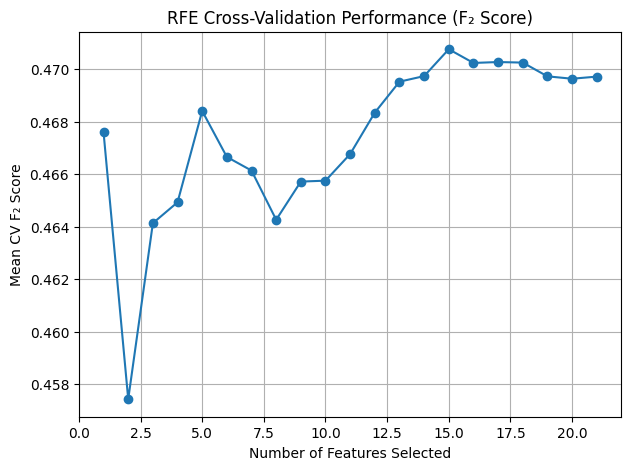

In [9]:
rfecv_log.fit(X_train_s, y_train)

print(f"Optimal number of features: {rfecv_log.n_features_}")
print("Selected features:")
print(X_train_s.columns[rfecv_log.support_].tolist())

# Plot performance vs number of features
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(
    range(1, len(rfecv_log.cv_results_['mean_test_score']) + 1),
    rfecv_log.cv_results_['mean_test_score'],
    marker='o'
)
plt.title("RFE Cross-Validation Performance (F₂ Score)")
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean CV F₂ Score")
plt.grid(True)
plt.show()

In [10]:
selected_features = X_train_s.columns[rfecv_log.support_]

print(f"Number of selected features: {len(selected_features)}")
print("Selected feature names:")
print(selected_features.tolist())

Number of selected features: 85
Selected feature names:
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'insulin', 'comorbidity_score', 'filtered_meds_count', 'service_utilization', 'race_Asian', 'race_Hispanic', 'race_Other', 'diabetesMed_Yes', 'discharge_disposition_name_Discharged to home', 'discharge_disposition_name_Discharged/transferred to SNF', 'discharge_disposition_name_Discharged/transferred to a federal health care facility.', 'discharge_disposition_name_Discharged/transferred to a long term care hospital.', 'discharge_disposition_name_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.', 'discharge_disposition_name_Discharged/transferred to another rehab fac including rehab units of a hospital .', 'discharge_disposition_name_Discharged/transferred to a

In [11]:
X_train_rfe_log = X_train_s[selected_features]
X_test_rfe_log  = X_test_s[selected_features]

In [12]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve, precision_recall_curve, f1_score, accuracy_score
)

In [27]:
best_lg_f2_rfe = rfecv_log.estimator_
y_pred_lg_f2_rfe_opt = best_lg_f2_rfe.predict(X_test_rfe_log)
y_pred_lg_f2_rfe_opt_proba = best_lg_f2_rfe.predict_proba(X_test_rfe_log)[:, 1]
y_tr_lg_pred_f2_rfe_opt = best_lg_f2_rfe.predict(X_train_rfe_log)
y_tr_lg_pred_f2_rfe_opt_proba = best_lg_f2_rfe.predict_proba(X_train_rfe_log)[:, 1]
y_pred_thr_lg_f2_rfe_opt = (y_pred_lg_f2_rfe_opt_proba >= t).astype(int)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lg_f2_rfe_opt):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_lg_f2_rfe_opt_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lg_f2_rfe_opt):.4f}\n")
print(f"F2-Score: {fbeta_score(y_test, y_pred_lg_f2_rfe_opt,beta=2):.4f}\n")
print(f"Accuracy Tr: {accuracy_score(y_train, y_tr_lg_pred_f2_rfe_opt):.4f}")
print(f"ROC-AUC Tr: {roc_auc_score(y_train, y_tr_lg_pred_f2_rfe_opt_proba):.4f}")
print(f"F1-Score Tr: {f1_score(y_train, y_tr_lg_pred_f2_rfe_opt):.4f}\n")
print(f"F2-Score Tr: {fbeta_score(y_train, y_tr_lg_pred_f2_rfe_opt,beta=2):.4f}\n")
print("Classification Report:")
y_pred_thr_lg_f2_rfe_opt = (y_pred_lg_f2_rfe_opt_proba >= t).astype(int)
print(classification_report(y_test, y_pred_thr_lg_f2_rfe_opt, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
print("Classification Report: Tr")
print(classification_report(y_train, y_tr_lg_pred_f2_rfe_opt, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
cm_rfe_lg_opt = confusion_matrix(y_test, y_pred_thr_lg_f2_rfe_opt)
print("\nConfusion Matrix:")
print(cm_rfe_lg_opt)
print(f"\nTrue Negatives:  {cm_rfe_lg_opt[0,0]}")
print(f"False Positives: {cm_rfe_lg_opt[0,1]}")
print(f"False Negatives: {cm_rfe_lg_opt[1,0]}")
print(f"True Positives:  {cm_rfe_lg_opt[1,1]}\n")

Accuracy: 0.6698
ROC-AUC: 0.7079
F1-Score: 0.3487

F2-Score: 0.4679

Accuracy Tr: 0.6718
ROC-AUC Tr: 0.7083
F1-Score Tr: 0.3540

F2-Score Tr: 0.4753

Classification Report:
                precision    recall  f1-score   support

Not Readmitted     0.9124    0.6575    0.7643     10094
    Readmitted     0.2394    0.6307    0.3470      1725

      accuracy                         0.6536     11819
     macro avg     0.5759    0.6441    0.5557     11819
  weighted avg     0.8142    0.6536    0.7034     11819

Classification Report: Tr
                precision    recall  f1-score   support

Not Readmitted     0.9121    0.6813    0.7800     40373
    Readmitted     0.2484    0.6161    0.3540      6902

      accuracy                         0.6718     47275
     macro avg     0.5802    0.6487    0.5670     47275
  weighted avg     0.8152    0.6718    0.7178     47275


Confusion Matrix:
[[6637 3457]
 [ 637 1088]]

True Negatives:  6637
False Positives: 3457
False Negatives: 637
True Positi

C:\Users\raiag\anaconda3\envs\enron_exams\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\raiag\anaconda3\envs\enron_exams\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\raiag\anaconda3\envs\enron_exams\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\raiag\anaconda3\envs\enron_exams\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## F2 -Scored Log Refined Model -  Post-refinement: All Plots (Confusion, ROC, PR, Threshold Curves, Top Coefs)

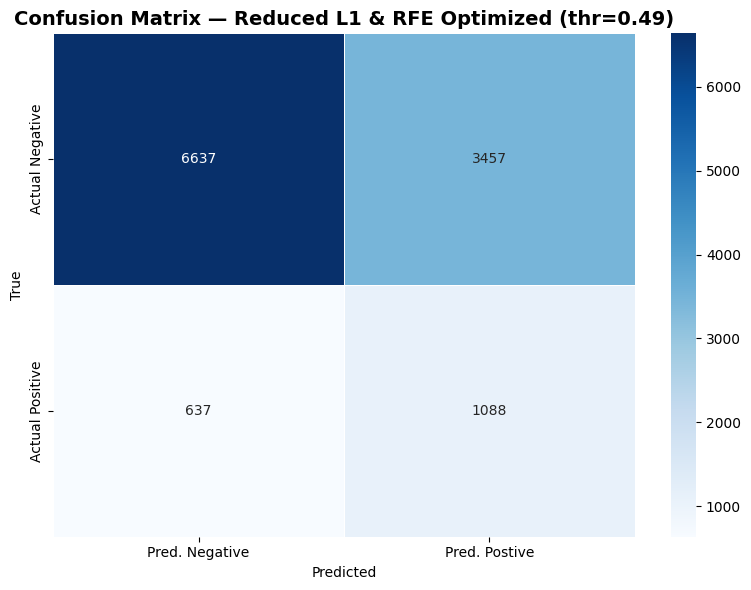

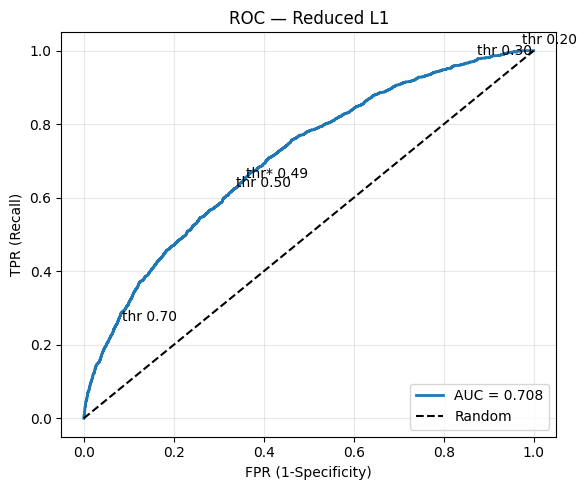

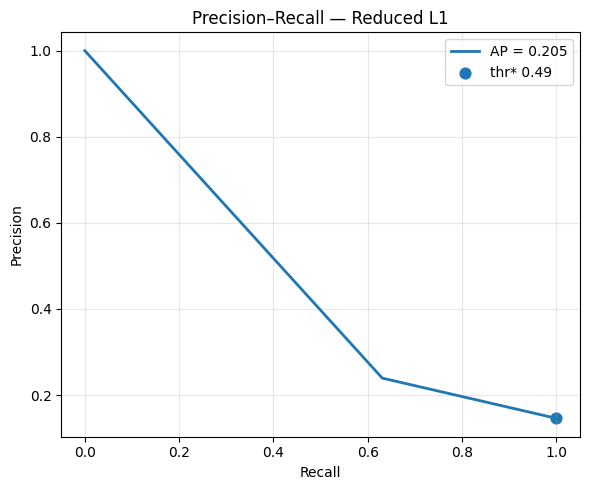

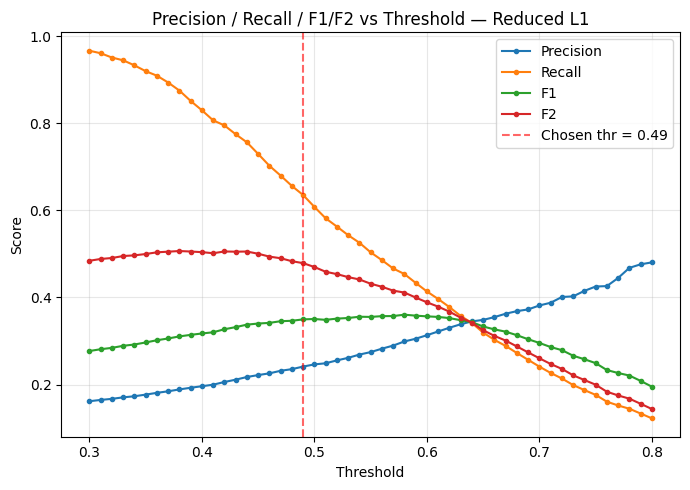

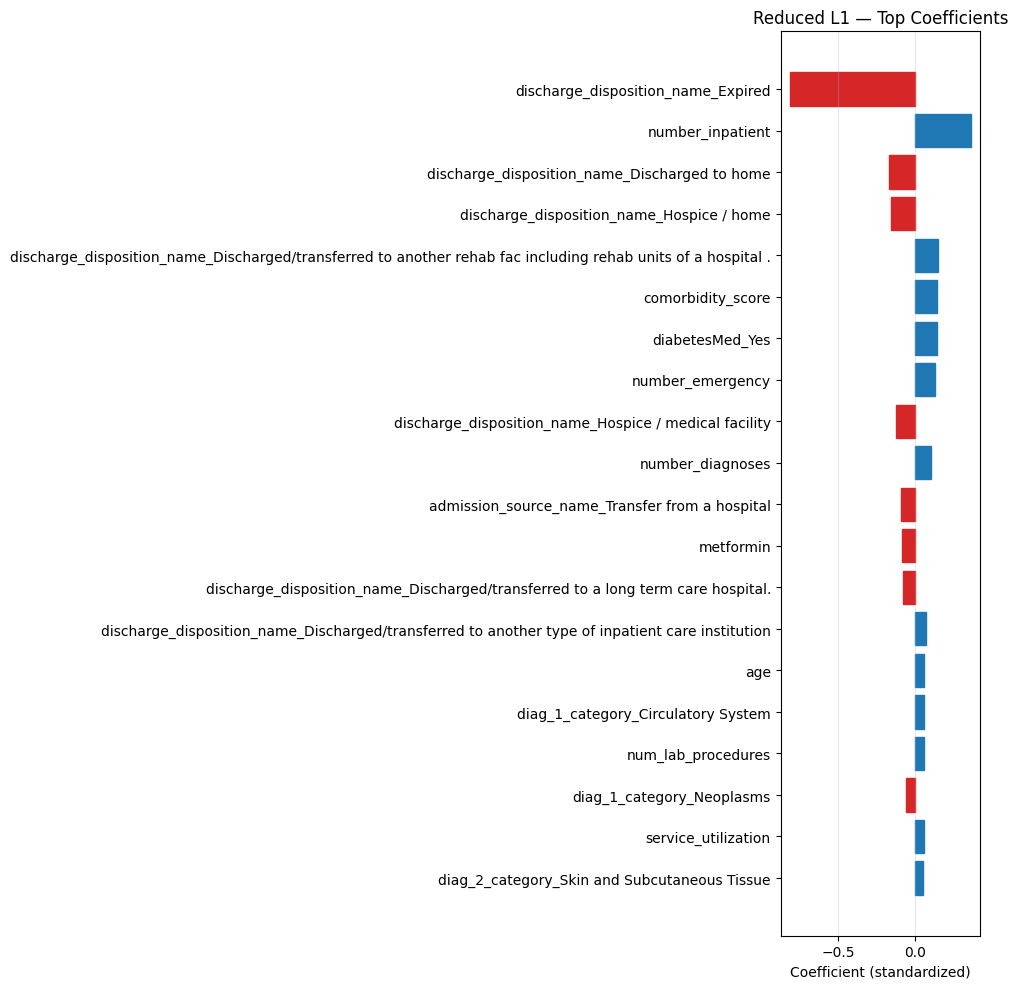

In [14]:
# ============================================
# 9) Post-refinement: All Plots (Confusion, ROC, PR, Threshold Curves, Top Coefs)
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfe_lg_opt, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred. Negative","Pred. Postive"], yticklabels=["Actual Negative","Actual Positive"],
            linewidths=0.5, linecolor="white")
plt.title(f"Confusion Matrix — Reduced L1 & RFE Optimized (thr={t:.2f})", fontsize=14, fontweight="bold")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ROC (annotated)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred_lg_f2_rfe_opt_proba); roc_auc2 = auc(fpr2, tpr2)
plt.figure(figsize=(6,5))
plt.plot(fpr2, tpr2, linewidth=2, label=f"AUC = {roc_auc2:.3f}")
plt.plot([0,1],[0,1],"k--", label="Random")
for thv in [0.2,0.3,0.5,0.7,t]:
    idx = np.argmin(np.abs(thr2 - thv)); lbl = f"thr {thv:.2f}" if thv!=t else f"thr* {thv:.2f}"
    plt.annotate(lbl, (fpr2[idx], tpr2[idx]), xytext=(6,6), textcoords="offset points")
plt.xlabel("FPR (1-Specificity)"); plt.ylabel("TPR (Recall)")
plt.title("ROC — Reduced L1"); plt.legend(loc="lower right"); plt.grid(True,alpha=0.3); plt.tight_layout(); plt.show()

# Precision–Recall (annotated)
prec2, rec2, pr_thr2 = precision_recall_curve(y_test, y_pred_thr_lg_f2_rfe_opt); ap2 = average_precision_score(y_test, y_pred_thr_lg_f2_rfe_opt)
plt.figure(figsize=(6,5))
plt.plot(rec2, prec2, linewidth=2, label=f"AP = {ap2:.3f}")
idxs = np.argmin(np.abs(pr_thr2 - t))
plt.scatter(rec2[idxs], prec2[idxs], s=60, label=f"thr* {t:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall — Reduced L1")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Threshold curves
plt.figure(figsize=(7,5))
plt.plot(thr_df["threshold"], thr_df["precision"], label="Precision", marker="o", ms=3)
plt.plot(thr_df["threshold"], thr_df["recall"],    label="Recall",    marker="o", ms=3)
plt.plot(thr_df["threshold"], thr_df["f1"],        label="F1",        marker="o", ms=3)
plt.plot(thr_df["threshold"], thr_df["f2"],        label="F2",        marker="o", ms=3)
plt.axvline(t, color="r", linestyle="--", alpha=0.6, label=f"Chosen thr = {t:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Precision / Recall / F1/F2 vs Threshold — Reduced L1")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Top coefficients (non-zero)
coefs2 = pd.Series(best_lg_f2_rfe.coef_[0], index=X_test_rfe_log.columns)
nz2 = coefs2[coefs2 != 0].sort_values(key=np.abs, ascending=False)
top_k = min(20, nz2.shape[0])
plot_df = nz2.head(top_k)

plt.figure(figsize=(10, max(5, 0.45*top_k + 1)))
bars = plt.barh(plot_df.index, plot_df.values)
plt.gca().invert_yaxis()
for b, v in zip(bars, plot_df.values):
    b.set_color("tab:blue" if v > 0 else "tab:red")
plt.xlabel("Coefficient (standardized)"); plt.title("Reduced L1 — Top Coefficients")
plt.grid(axis="x", alpha=0.3); plt.tight_layout(); plt.show()

# **🧮 Final Logistic Regression Equation**

Displays the mathematical form of the final reduced L1 logistic regression model.

In [15]:
# ============================================
# 🧮 Final Logistic Regression Equation (Reduced Model)
# ============================================

# Intercept
intercept = best_lg_f2_rfe.intercept_[0]

# Coefficients
coefs_final = pd.Series(best_lg_f2_rfe.coef_[0], index=X_test_rfe_log.columns)
coefs_final = coefs_final[coefs_final != 0]  # keep only non-zero terms

# Print equation
print("\n🧮 Final Logistic Regression (L1 RFE + F2 Optimized) Equation:")
print("----------------------------------------------------")
print("log(p / (1 - p)) = ", end="")
print(f"{intercept:.4f}", end="")

for feature, coef in coefs_final.items():
    sign = " + " if coef >= 0 else " - "
    print(f"{sign}{abs(coef):.4f} * {feature}", end="")

print("\n\n✅ Equation Summary:")
print(f"- Intercept: {intercept:.4f}")
print(f"- Non-zero features: {len(coefs_final)} / {len(X_test_rfe_log.columns)}")
print(f"- Average coefficient magnitude: {coefs_final.abs().mean():.4f}")

# ============================================
# 📋 Feature Summary — Reduced Model (Non-zero Coefficients)
# ============================================

coefs_all = pd.Series(best_lg_f2_rfe.coef_[0], index=X_test_rfe_log.columns)
coefs_all = coefs_all[coefs_all != 0].sort_values(ascending=False)

# Split into positive and negative effects
positive_feats = coefs_all[coefs_all > 0]
negative_feats = coefs_all[coefs_all < 0]

print("\n✅ Total selected features:", len(coefs_all))
print(f"🔹 Positive predictors (increase log-odds of readmission): {len(positive_feats)}")
print(f"🔻 Negative predictors (decrease log-odds of readmission): {len(negative_feats)}\n")

# Display top features by sign
print("🔹 Positive predictors (β > 0):")
for f, v in positive_feats.items():
    print(f"  + {f:30s}  ({v:.4f})")

print("\n🔻 Negative predictors (β < 0):")
for f, v in negative_feats.items():
    print(f"  - {f:30s}  ({v:.4f})")


🧮 Final Logistic Regression (L1 RFE + F2 Optimized) Equation:
----------------------------------------------------
log(p / (1 - p)) = -0.2155 + 0.0607 * age + 0.0492 * time_in_hospital + 0.0591 * num_lab_procedures - 0.0478 * num_procedures + 0.0268 * num_medications + 0.1294 * number_emergency + 0.3651 * number_inpatient + 0.1050 * number_diagnoses + 0.0252 * max_glu_serum - 0.0304 * A1Cresult - 0.0828 * metformin - 0.0310 * glimepiride - 0.0150 * pioglitazone - 0.0311 * insulin + 0.1466 * comorbidity_score + 0.0485 * filtered_meds_count + 0.0583 * service_utilization - 0.0238 * race_Asian - 0.0208 * race_Hispanic - 0.0260 * race_Other + 0.1452 * diabetesMed_Yes - 0.1675 * discharge_disposition_name_Discharged to home + 0.0373 * discharge_disposition_name_Discharged/transferred to SNF - 0.0153 * discharge_disposition_name_Discharged/transferred to a federal health care facility. - 0.0762 * discharge_disposition_name_Discharged/transferred to a long term care hospital. - 0.0241 * disc